# Hydromass example

Let's start by loading the packages...

In [1]:
import numpy as np

import pyproffit

import hydromass

import matplotlib.pyplot as plt


We start by loading the images in pyproffit using the pyproffit.Data class

1. Here imglink=_'epic-obj-im-700-1200.fits'_ is the link to the image file (count map) to be loaded.
2. The option _explink=_'epic-exp-im-700-1200.fits' allows the user to load an exposure map for vignetting correction. In case this option is left blank, a uniform exposure of 1s is assumed for the observation.   
3. The option _bkglink=_'epic-back-oot-sky-700-1200.fits' allows to load an external background map, which will be used when extracting surface brightness profiles.

The images are then loaded into the _Data_ structure

In [2]:
datv = pyproffit.Data(imglink='../../cluster_data/VLP/MACS0451/epic-obj-im-700-1200.fits',
                    explink='../../cluster_data/VLP/MACS0451/epic-exp-im-700-1200.fits',
                    bkglink='../../cluster_data/VLP/MACS0451/comb-back-tot-sky-700-1200.fits')

# To load instead a Voronoi image:
#datv=pyproffit.Data('../../cluster_data/VLP/MACS0451/voronoi_MACS0451.fits',voronoi=True)

# Filter out point sources by loading a DS9 region file
datv.region('../../cluster_data/VLP/MACS0451/src_voronoi.reg')



Excluded 41 sources


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


<h2> Profile extraction </h2>

Now we define a _Profile_ object and fit the background with a constant.

<p>The class <i>Profile</i> is designed to contain all the Proffit profile extraction features (not all of them have been implemented yet). The "method" argument specifies the choice of the center:
<blockquote>
    <p> center_choice='<i>centroid</i>': compute image centroid and ellipticity </p>
    <p> center_choice='<i>peak</i>': use brightness peak </p>
    <p> center_choice='<i>custom_fk5</i>': use custom center in FK5 coordinates, provided by the "center_ra" and "center_dec" arguments
    <p> center_choice='<i>custom_ima</i>': like <i>custom_fk5</i> but with input coordinates in image pixels
</blockquote>
</p>

The other arguments are the following:
<blockquote>
    <p> maxrad=<i>rad</i>: define the maximum radius of the profile (in arcmin) </p>
    <p> binsize=<i>size</i>: the width of the bins (in arcsec) </p>
    <p> center_ra=<i>ra</i>, center_dec=<i>dec</i>: position of the center (if method=3 or method=4) </p>
    <p> binning='<i>binning</i>': specify binnig scheme: <i>linear</i> (default), <i>log</i>, or <i>custom</i>. In the <i>custom</i> case, an array with the binning definition should be provided through the option bins=<i>array</i>
    <p> centroid_region=<i>radius</i>: for centroid calculation (center_choice=<i>centroid</i>), optionally provide a radius within which the centroid will be computed, instead of the entire image.
</blockquote>

<h3> Now let's extract the profile...</h3>


In [3]:

prof = pyproffit.Profile(datv, center_choice='peak', binsize=5, maxrad=15.)


prof.SBprofile()

mod = pyproffit.Model(pyproffit.Const)
fitter = pyproffit.Fitter(model=mod, profile=prof)
fitter.Migrad(fitlow=7., fithigh=15., pedantic=False)


Determining X-ray peak
Coordinates of surface-brightness peak: 428.0 416.0
Corresponding FK5 coordinates:  73.5456401039549 -3.0148262711063816


<Figure size 432x288 with 0 Axes>

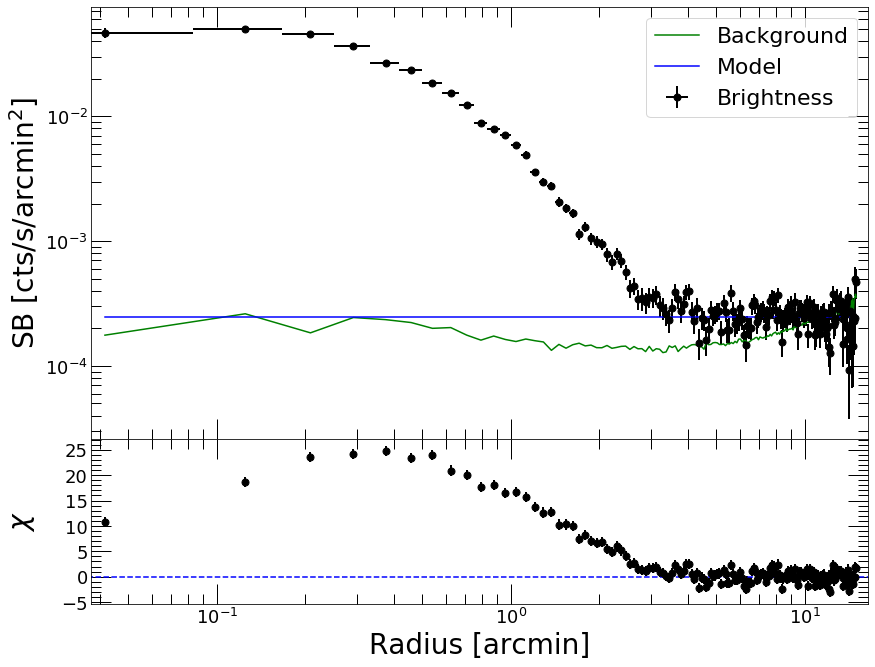

In [4]:

prof.Plot(model=mod)

Here we have fitted the background with a constant in the radial range 7-15 arcmin. 

Now let's extract a new profile with logarithmic binning and subtract the fitted background

Determining X-ray peak
Coordinates of surface-brightness peak: 428.0 416.0
Corresponding FK5 coordinates:  73.5456401039549 -3.0148262711063816


<Figure size 432x288 with 0 Axes>

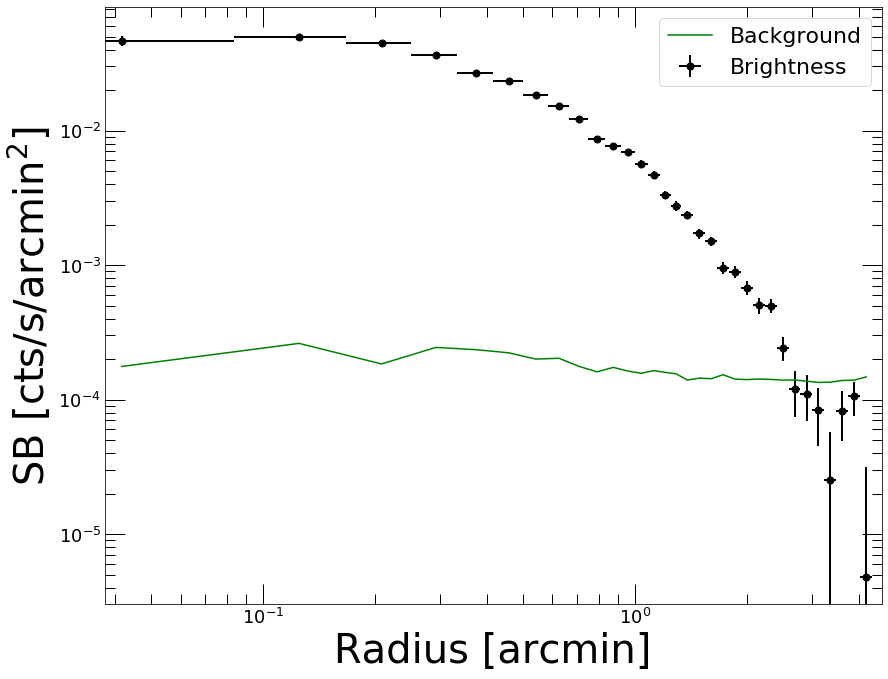

In [5]:
p2 = pyproffit.Profile(datv, center_choice='peak', binsize=5, maxrad=4.5, binning='log')
# p2.MedianSB()
p2.SBprofile()
p2.Backsub(fitter)

p2.Plot()

## Model the PSF

To model the PSF we can either supply a function or an image. The function should take an array of radii (in arcmin) and return the 1D PSF profile.


In [6]:
def fking(x):
    r0=0.0883981
    alpha=1.58918
    return np.power(1.+(x/r0)**2,-alpha)

p2.PSF(psffunc=fking)


Now we need to define some parameters of our source

In [7]:
z_m0451 = 0.5398 # redshift
nh_m0451 = 0.0454 # NH
rsp = '/home/deckert/Documents/Work/cluster_data/scripts/m1.rsp' # on-axis response file


# Hydromass definition

We are now ready to load the hydromass.Mhyd class. 

The constructor of the Mhyd class requires the following input:
<blockquote>
    <p> profile=<i>prof</i>: a pyproffit.Profile object including the SB profile </p>
    <p> spec_data=<i>file</i>: a FITS file containing spectral data, using the usual X-COP format </p>
    <p> sz_data=<i>file</i>: a FITS file containing the Planck data in Etienne's format </p>
    <p> redshift=<i>z</i>: source redshift </p>
    <p> cosmo=<i>cosmo</i>: adopted cosmology in astropy.cosmology format. If cosmo=None (default), use Planck15.</p>
    <p> directory=<i>dir</i>: name of output file directory. If directory=None (default), a subdirectory with name 'mhyd' will be created. </p>
    <p> f_abund='<i>angr</i>': abundance table definition for calculation of electron to proton ratio and mean molecular weight. Default='angr', also available are 'aspl' and 'grsa'.</p>
</blockquote>

Note that either spec_data or sz_data or both can be specified. 

In [8]:
tmhyd = hydromass.Mhyd(profile=p2, 
                       spec_data='../../cluster_data/VLP/MACS0451/spectral_results_MACS0451.fits',
                       redshift=z_m0451, 
                       cosmo=pyproffit.cosmo)


No output directory name provided, will output to subdirectory "mhyd" 
Luminosity distance to the source: 3152.47 Mpc
At the redshift of the source 1 arcmin is 386.766 kpc
Reading spectral data from file ../../cluster_data/VLP/MACS0451/spectral_results_MACS0451.fits


# Hydromass.Model class

Now let us define a mass model. This is done with the hydromass.Model class, which accepts the following option:

<blockquote>
    <p> massmod=<i>NFW</i>: mass model definition. Available models are NFW, EIN2, EIN3, BUR, ISO, and HER. </p>
    <p> delta=<i>val</i>: overdensity at which R_delta and c_delta are defined in the model (default=200). </p>
    <p> start=<i>start</i>: an array containing the mean values of the Gaussian priors on the parameters. If None, default values for each model will be set. </p>
    <p> sd=<i>sd</i>: an array contianing the sigma of the Gaussian priors on the parameters. If None, default values for each model will be set.</p>
    <p> limits=<i>limits</i>: a 2D-array containing upper and lower limits for the parameter values. If None, default values for each model will be set.</p>
    <p> fixed=<i>fix</i>: a boolean array describing if a parameter is fixed or fitted. For instance, for a model with 2 parameters for which we want to fix the first one, we pass fix=[True, False]. If fix=True, the value given in start is used. By default all parameters are fitted. </p>
</blockquote>

Now let's define an NFW model with default parameters

In [9]:

model = hydromass.Model(massmod='NFW')


## Emissivity conversion

Now we need to compute the conversion factor between count rate and emissivity. This is done by running an XSPEC command under the hood, so XSPEC must be accessible:

In [10]:
tmhyd.emissivity(nh=nh_m0451, rmf=rsp, elow=0.7, ehigh=1.2)

print('Conversion between count rate and emission measure: ', tmhyd.ccf)

Mean cluster temperature: 8.161195  keV
Conversion between count rate and emission measure:  21.2


## Running the code

We are now ready to run the reconstruction. This is done using the Mhyd.run() function, which supports the following parameters:

<blockquote>
    <p> model=<i>model</i>: hydromass.Model object containing the definition of the mass model. </p>
    <p> nmcmc=<i>1000</i>: number of output samples from PyMC3/NUTS run (default=1000).</p>
    <p> tune=<i>500</i>: number of PyMC3/NUTS tuning steps (default=500). Increasing the <i>tune</i> value leads to better convergence but slower runs.</p>
    <p> nmore=<i>5</i>: fine grid definition for mass model calculation. The spec_data/sz_data grid will be split into 2*nmore bins inside which mass and pressure derivatives will be computed. Increasing nmore leads to greater precision in model pressure calculaton, but obviously slower runs. </p>
    <p> p0_prior=<i>p0_prior</i>: array containing the mean and standard deviation of the Gaussian prior on P0.</p>
    <p> dmonly=<i>False</i>: decide whether we want to fit the total mass or the DM mass only by subtracing the baryonic mass (default=False).</p>
    <p> mstar=<i>mstar</i>: in case dmonly=True, input a stellar mass profile as a 2D array including R (in kpc) and M_star (in Msun) in the two columns. </p>
    <p> fit_bkg=<i>False</i>: choose whether we want to fit the background on-the-fly and the counts using Poisson statistics, or if we use directly a background-subtracted brightness profile (default option), in which case Gaussian statistics is used. </p>
    <p> bkglim=<i>bkglim</i>: in case fit_bkg=True, set the maximum detection radius beyond which it is assumed that the source is negligible with respect to the background. If bkglim=None it will be assumed that the source is important everywhere.</p>
    <p> back=<i>back</i>: in case fit_bkg=True, give an input value for the background and set a narrow Gaussian prior centered on this value. If back=None the input value will be estimated as the mean value at r>bkglim.</p>
    <p> samplefile=<i>file</i>: name of output file to save the final PyMC3/NUTS samples.
</blockquote>


### Now let's do a quick test run...

In [11]:
# tmhyd.run(model=model, fit_bkg=True, bkglim=4.5)


tmhyd.run(model=model, p0_prior=[5e-4, 5e-4], nmcmc=100, tune=100)

Running MCMC...


logp = 18.452, ||grad|| = 0.0052633: 100%|██████████| 624/624 [00:00<00:00, 1631.91it/s] 
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logp0, rdelta, cdelta, coefs]
Sampling 4 chains, 155 divergences: 100%|██████████| 800/800 [00:23<00:00, 33.45draws/s]
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5907644601864205, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6875268434272935, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_tre

Done.
 Total computing time is:  0.5318603277206421  minutes


### Let's plot the distribution of sample values at R500

<Figure size 432x288 with 0 Axes>

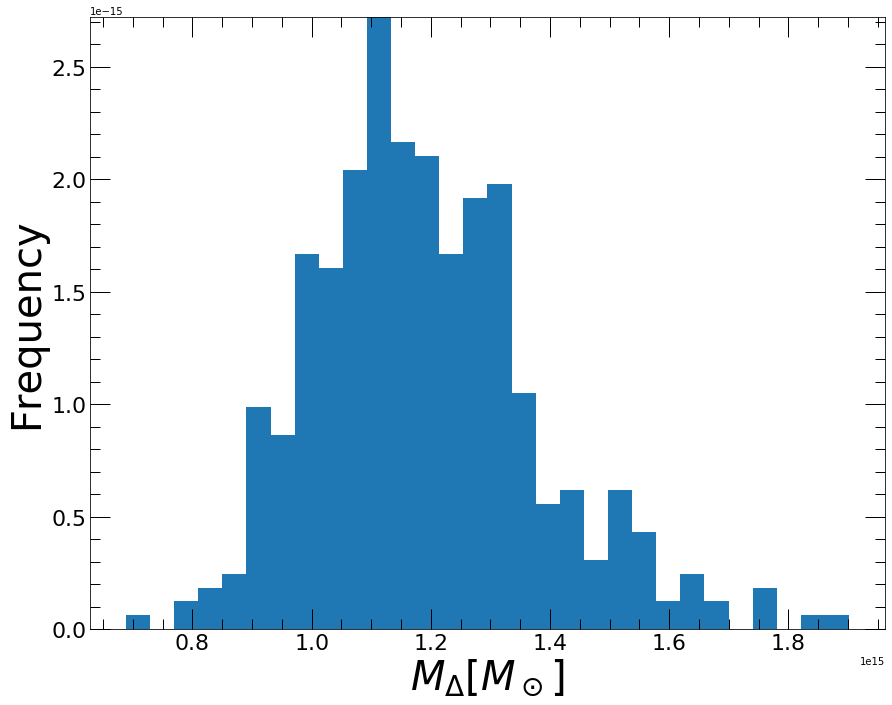

In [12]:
res_r500, fig = hydromass.calc_rdelta_mdelta(500, tmhyd, model, plot=True)

### ... And write the results at various overdensities to a file

In [13]:
hydromass.write_all_mdelta(tmhyd, model)

### Now let us inspect the results a little bit

pymc3 includes the "traceplot" function which allows to check the behavior of the output chains

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f09128d6880>,
      dtype=object)

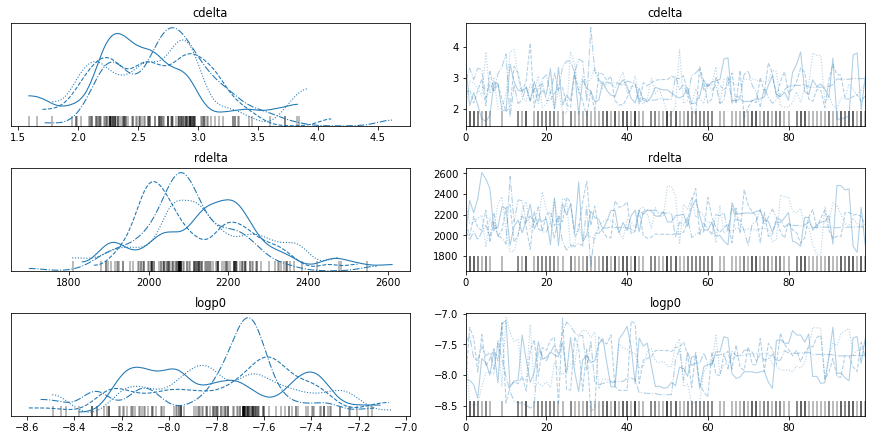

In [14]:
import pymc3 as pm

pm.traceplot(tmhyd.trace, var_names=['cdelta','rdelta','logp0'])

In [15]:
print(np.median(tmhyd.samppar[:,0]))
print(np.median(tmhyd.samppar[:,1]))

2.6419214071036707
2115.0377625508645


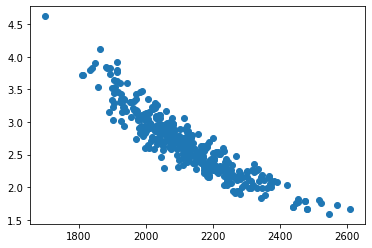

In [16]:
plt.plot(tmhyd.samppar[:,1], tmhyd.samppar[:,0], 'o')

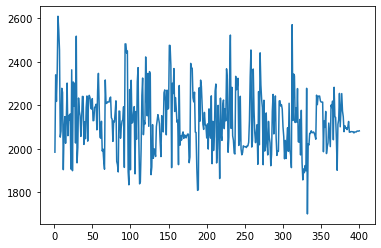

In [17]:
plt.plot(np.arange(1,len(tmhyd.samppar[:,1])+1,1), tmhyd.samppar[:,1])

Despite the small number of samples and tuning steps, the chain has converged. Now let's check the quality of the fit.

In [18]:
print(np.percentile(tmhyd.samppar[:,1], [50.-68.3/2., 50., 50.+68.3/2.]))

[1990.45592539 2115.03776255 2262.30231715]


<ErrorbarContainer object of 3 artists>

<Figure size 432x288 with 0 Axes>

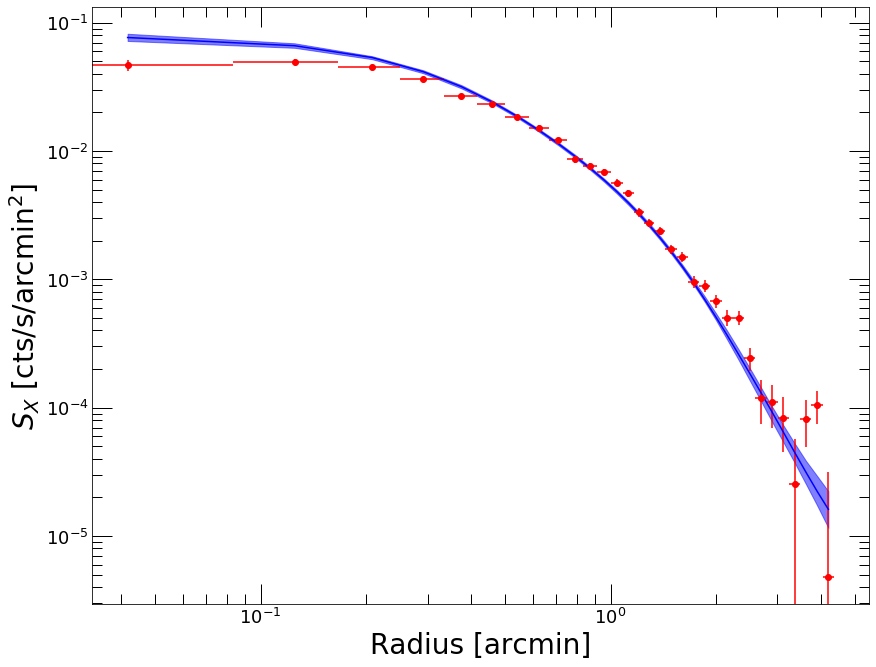

In [19]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [arcmin]', fontsize=28)
plt.ylabel('$S_{X}$ [cts/s/arcmin$^2$]', fontsize=28)

plt.plot(p2.bins, tmhyd.sb, color='blue')
plt.fill_between(p2.bins, tmhyd.sb_lo, tmhyd.sb_hi, color='blue', alpha=0.5)
plt.errorbar(p2.bins, p2.profile, xerr=p2.ebins, yerr=p2.eprof, fmt='o', color='red')

# Looks good

## Now for the temperature profile...

<Figure size 432x288 with 0 Axes>

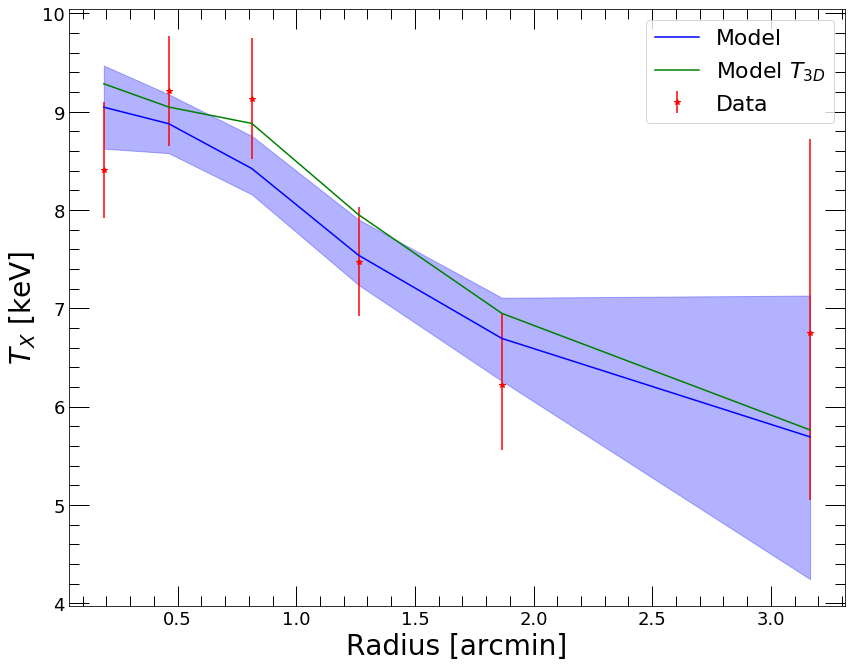

In [20]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)

plt.xlabel('Radius [arcmin]', fontsize=28)
plt.ylabel('$T_{X}$ [keV]', fontsize=28)
plt.errorbar(tmhyd.rref_x_am,tmhyd.temp_x,yerr=np.array([tmhyd.templ,tmhyd.temph]),fmt='*',color='red', label='Data')
plt.plot(tmhyd.rref_x_am,tmhyd.ktmod,color='blue', label='Model')
plt.fill_between(tmhyd.rref_x_am, tmhyd.ktmod_lo, tmhyd.ktmod_hi, color='blue', alpha=0.3)
plt.plot(tmhyd.rref_x_am,tmhyd.kt3d,color='green', label='Model $T_{3D}$')

plt.legend(fontsize=22)

### Let's inspect the mass profile

In [21]:
res_profile = hydromass.prof_hires(tmhyd, model)

res_mass = hydromass.mass_from_samples(tmhyd, model)


<Figure size 432x288 with 0 Axes>

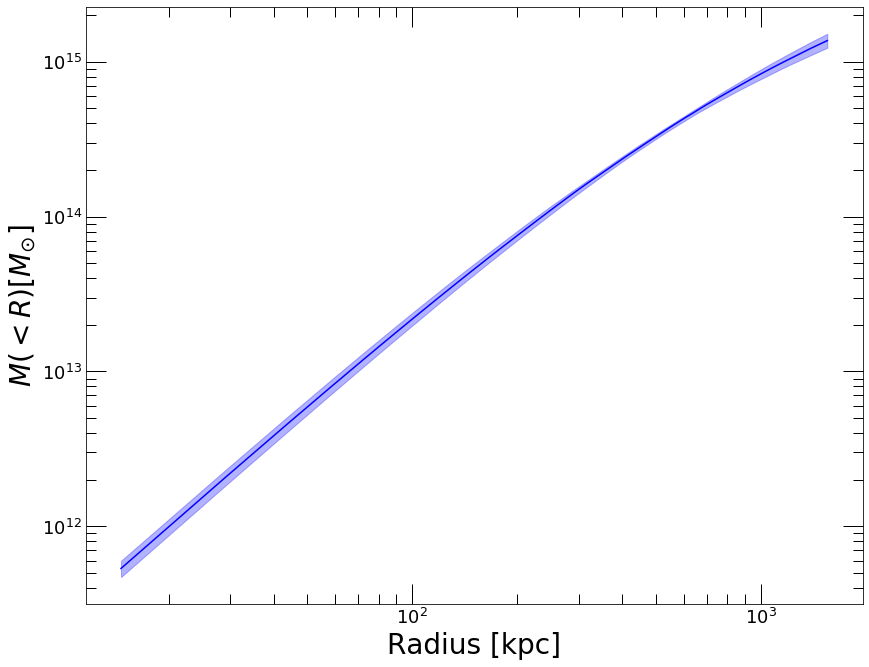

In [22]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)

plt.xlabel('Radius [kpc]', fontsize=28)
plt.ylabel('$M(<R) [M_{\odot}]$', fontsize=28)
plt.yscale('log')
plt.xscale('log')
plt.plot(res_mass['R_OUT'], res_mass['MASS'],color='blue')
plt.fill_between(res_mass['R_OUT'], res_mass['MASS_LO'], res_mass['MASS_HI'], color='blue', alpha=0.3)


In [23]:
from astropy.io import fits

fold = fits.open('../../cluster_data/VLP/MACS0451/MACS0451_hydro_mass.fits')
dold = fold[1].data
rold = dold['RADIUS']
mold = dold['M_NFW']
mold_lo = dold['M_NFW_LO']
mold_hi = dold['M_NFW_HI']

fold.close()

<Figure size 432x288 with 0 Axes>

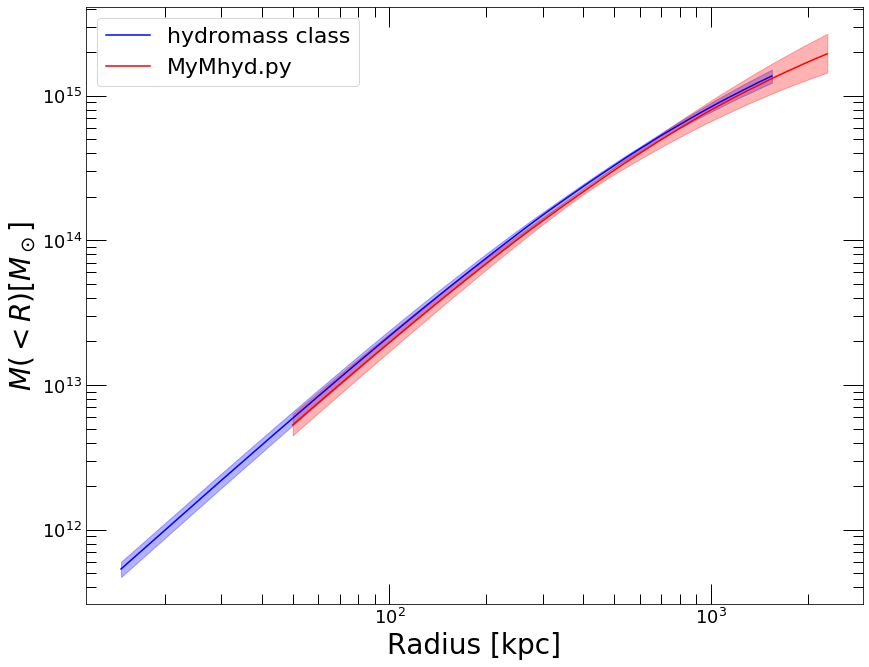

In [24]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=28)
plt.ylabel('$M(<R) [M_\odot]$', fontsize=28)
plt.plot(res_mass['R_OUT'], res_mass['MASS'],color='blue', label='hydromass class')
plt.fill_between(res_mass['R_OUT'], res_mass['MASS_LO'], res_mass['MASS_HI'], color='blue', alpha=0.3)

plt.plot(rold, mold, color='red', label='MyMhyd.py')
plt.fill_between(rold, mold_lo, mold_hi, color='red', alpha=0.3)
plt.legend(fontsize=22)
#plt.savefig('tests/MACS0451_code_comparison.pdf')
# Hurray!

## Now let's redo the same thing with the Einasto model

In [25]:
modein3 = hydromass.Model(massmod='EIN3')

In [26]:
mhydein3 = hydromass.Mhyd(profile=p2, 
                          spec_data='../../cluster_data/VLP/MACS0451/spectral_results_MACS0451.fits', 
                          redshift=z_m0451, 
                          cosmo=pyproffit.cosmo)

No output directory name provided, will output to subdirectory "mhyd" 
Luminosity distance to the source: 3152.47 Mpc
At the redshift of the source 1 arcmin is 386.766 kpc
Reading spectral data from file ../../cluster_data/VLP/MACS0451/spectral_results_MACS0451.fits


In [27]:
mhydein3.emissivity(nh=nh_m0451, rmf=rsp, elow=0.7, ehigh=1.2)

Mean cluster temperature: 8.161195  keV


In [28]:
mhydein3.run(model=modein3, nmcmc=100, tune=100)

Running MCMC...


logp = 17.961, ||grad|| = 0.033435: 100%|██████████| 1167/1167 [00:00<00:00, 1657.29it/s]
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logp0, mu, rdelta, cdelta, coefs]
Sampling 4 chains, 187 divergences: 100%|██████████| 800/800 [00:25<00:00, 31.29draws/s]
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.46651849590645, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.679057310726577, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_tr

Done.
 Total computing time is:  0.5648378014564515  minutes


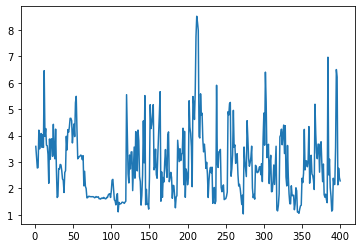

In [29]:
plt.plot(np.arange(1,len(mhydein3.samppar[:,2])+1,1), mhydein3.samppar[:,2])

<Figure size 432x288 with 0 Axes>

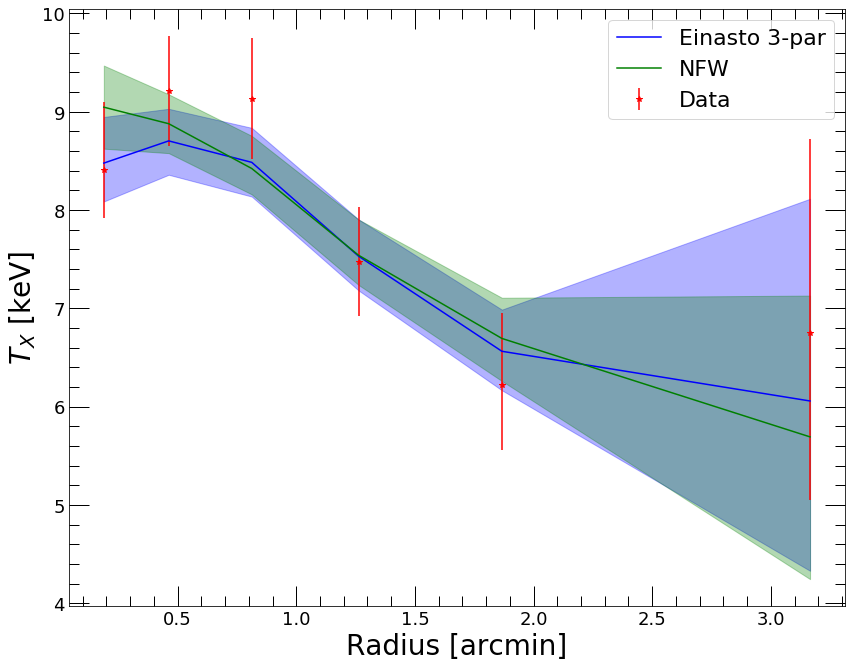

In [30]:
plt.clf()

plt.clf()

fig = plt.figure(figsize=(13,10))
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)

plt.xlabel('Radius [arcmin]', fontsize=28)
plt.ylabel('$T_{X}$ [keV]', fontsize=28)
plt.errorbar(mhydein3.rref_x_am,mhydein3.temp_x,yerr=np.array([mhydein3.templ,mhydein3.temph]),fmt='*',color='red', label='Data')
plt.plot(mhydein3.rref_x_am,mhydein3.ktmod,color='blue', label='Einasto 3-par')
plt.fill_between(mhydein3.rref_x_am, mhydein3.ktmod_lo, mhydein3.ktmod_hi, color='blue', alpha=0.3)
plt.plot(tmhyd.rref_x_am,tmhyd.ktmod,color='green', label='NFW')
plt.fill_between(tmhyd.rref_x_am, tmhyd.ktmod_lo, tmhyd.ktmod_hi, color='green', alpha=0.3)

plt.legend(fontsize=22)


In [31]:
res_ein = hydromass.mass_from_samples(mhydein3, modein3)


<Figure size 432x288 with 0 Axes>

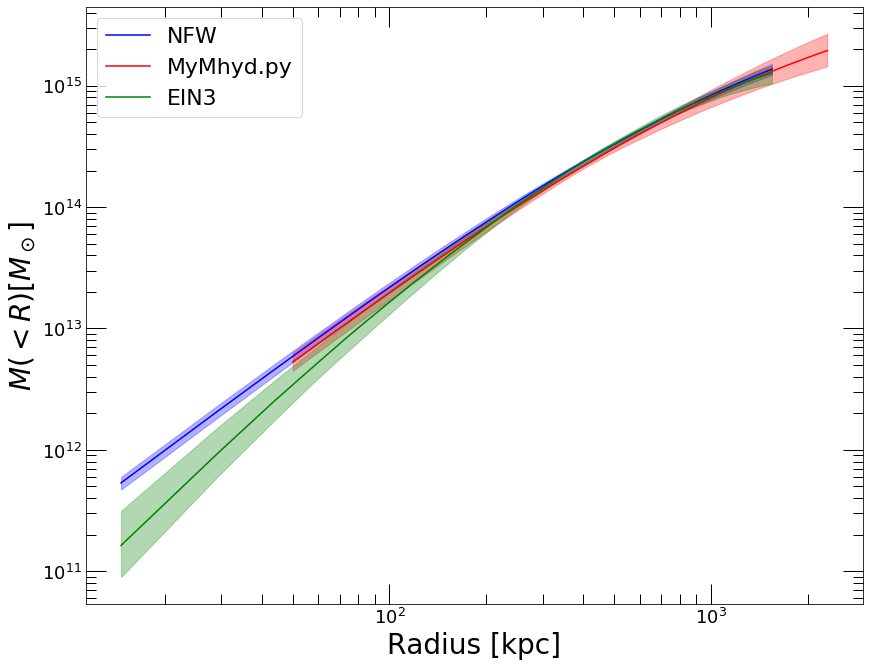

In [32]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=28)
plt.ylabel('$M(<R) [M_\odot]$', fontsize=28)
plt.plot(res_mass['R_OUT'], res_mass['MASS'],color='blue', label='NFW')
plt.fill_between(res_mass['R_OUT'], res_mass['MASS_LO'], res_mass['MASS_HI'], color='blue', alpha=0.3)

plt.plot(rold, mold, color='red', label='MyMhyd.py')
plt.fill_between(rold, mold_lo, mold_hi, color='red', alpha=0.3)

plt.plot(res_ein['R_OUT'], res_ein['MASS'],color='green', label='EIN3')
plt.fill_between(res_ein['R_OUT'], res_ein['MASS_LO'], res_ein['MASS_HI'], color='green', alpha=0.3)

plt.legend(fontsize=22)
#plt.savefig('tests/MACS0451_code_comparison.pdf')
# Hurray!

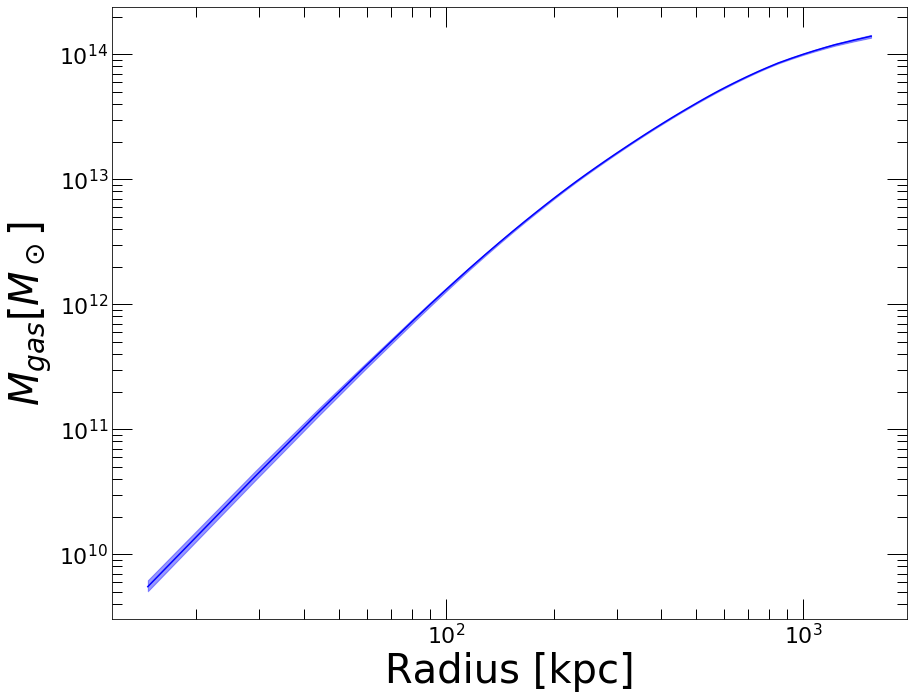

In [33]:
mgein, mgein_lo, mgein_hi, fig = hydromass.PlotMgas(mhydein3, plot=True)

(array([13., 28., 59., 22., 30., 28., 34., 27., 26., 22., 24., 16., 22.,
         9.,  7.,  7.,  8.,  4.,  4.,  1.,  1.,  3.,  0.,  1.,  0.,  0.,
         1.,  1.,  0.,  2.]),
 array([1.03319646, 1.28291084, 1.53262522, 1.7823396 , 2.03205398,
        2.28176836, 2.53148274, 2.78119712, 3.0309115 , 3.28062588,
        3.53034025, 3.78005463, 4.02976901, 4.27948339, 4.52919777,
        4.77891215, 5.02862653, 5.27834091, 5.52805529, 5.77776967,
        6.02748405, 6.27719843, 6.52691281, 6.77662719, 7.02634157,
        7.27605595, 7.52577033, 7.77548471, 8.02519909, 8.27491347,
        8.52462785]),
 <a list of 30 Patch objects>)

<Figure size 432x288 with 0 Axes>

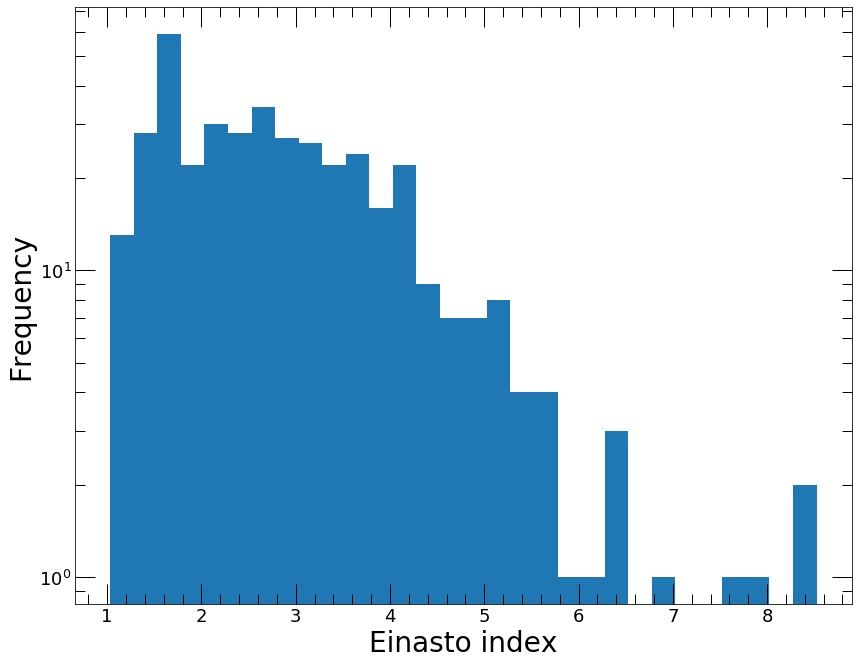

In [34]:
plt.clf()
fig=plt.figure(figsize=(13, 10))
ax = fig.add_axes(ax_size)
ax.minorticks_on()

ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Einasto index', fontsize=28)
plt.ylabel('Frequency', fontsize=28)
plt.hist(mhydein3.samppar[:,2], bins=30)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f090b923790>,
      dtype=object)

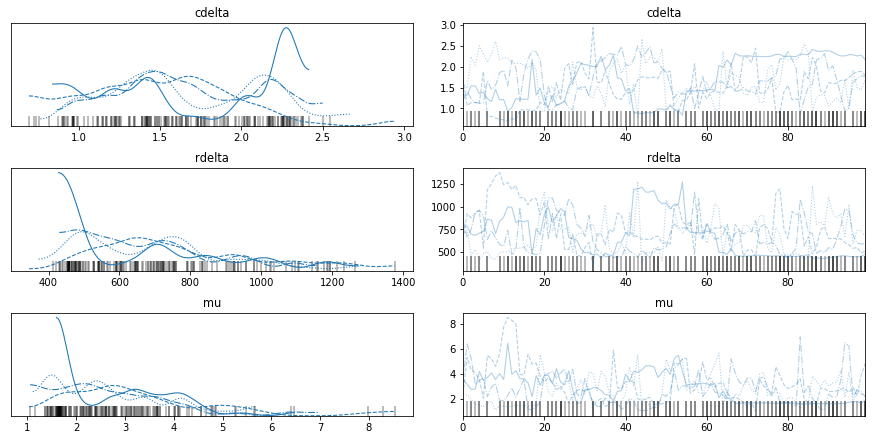

In [35]:
pm.traceplot(mhydein3.trace, var_names=['cdelta', 'rdelta', 'mu'])

# DM-only mass fit

Here we subtract the gas mass when performing the fit such that the best-fit model describes the contribution of dark matter only. No stellar mass is provided, but it can be easily added as an external constraint.

In [36]:
mnfwdm = hydromass.Mhyd(profile=p2, 
                        spec_data='../../cluster_data/VLP/MACS0451/spectral_results_MACS0451.fits', 
                        redshift=z_m0451, 
                        cosmo=pyproffit.cosmo)

modnfwdm = hydromass.Model(massmod='NFW')

mnfwdm.emissivity(nh=nh_m0451, rmf=rsp, elow=0.7, ehigh=1.2)

No output directory name provided, will output to subdirectory "mhyd" 
Luminosity distance to the source: 3152.47 Mpc
At the redshift of the source 1 arcmin is 386.766 kpc
Reading spectral data from file ../../cluster_data/VLP/MACS0451/spectral_results_MACS0451.fits
Mean cluster temperature: 8.161195  keV


In [37]:
mnfwdm.run(model=modnfwdm, nmcmc=100, tune=100, dmonly=True)

Running MCMC...


logp = 18.644, ||grad|| = 0.069453: 100%|██████████| 946/946 [00:00<00:00, 1845.58it/s]  
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logp0, rdelta, cdelta, coefs]
Sampling 4 chains, 192 divergences: 100%|██████████| 800/800 [00:25<00:00, 31.82draws/s]
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6525641144367706, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6430527837464154, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_tre

Done.
 Total computing time is:  0.53862650791804  minutes


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f090b0deee0>,
      dtype=object)

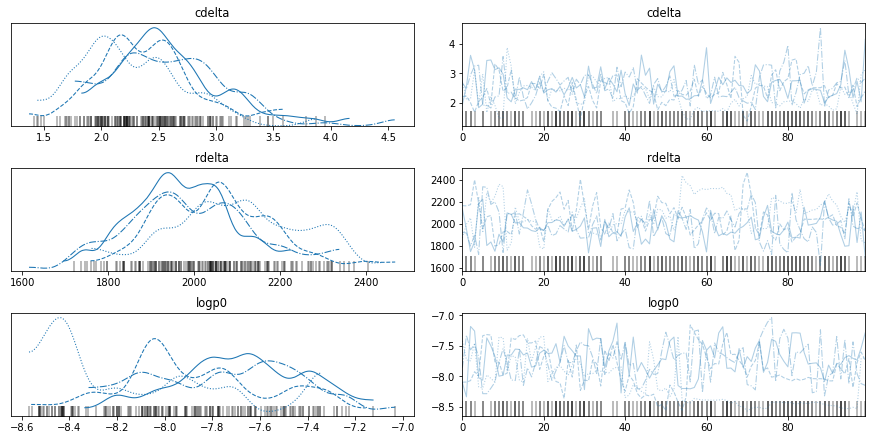

In [38]:
pm.traceplot(mnfwdm.trace, var_names=['cdelta', 'rdelta', 'logp0'])

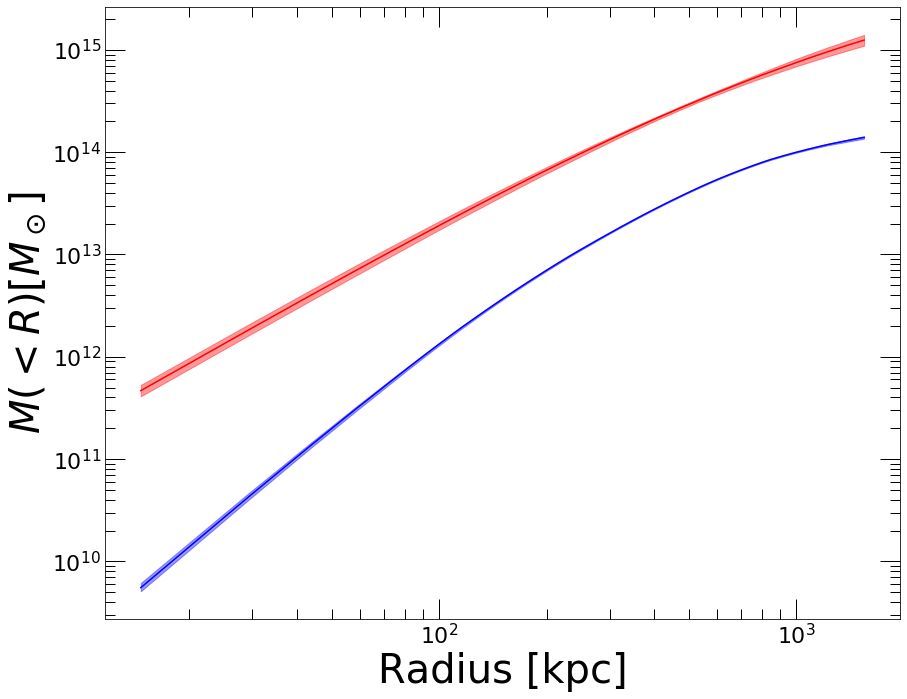

In [39]:
res_mdm, fig = hydromass.mass_from_samples(Mhyd=mnfwdm, model=modnfwdm, plot=True)


<Figure size 432x288 with 0 Axes>

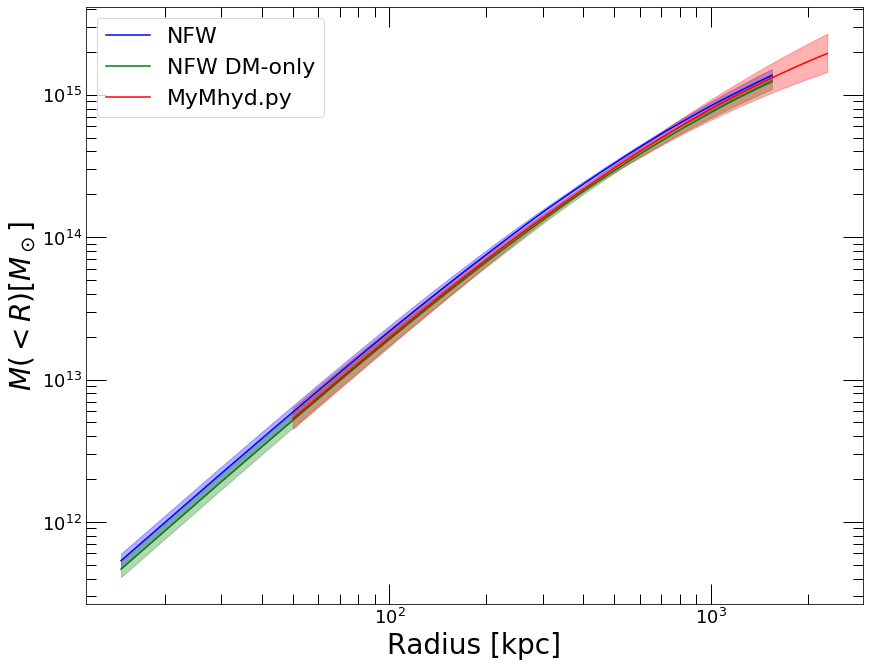

In [40]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=28)
plt.ylabel('$M(<R) [M_\odot]$', fontsize=28)
plt.plot(res_mass['R_OUT'], res_mass['MASS'],color='blue', label='NFW')
plt.fill_between(res_mass['R_OUT'], res_mass['MASS_LO'], res_mass['MASS_HI'], color='blue', alpha=0.3)

plt.plot(res_mdm['R_OUT'], res_mdm['MASS'],color='green', label='NFW DM-only')
plt.fill_between(res_mdm['R_OUT'], res_mdm['MASS_LO'], res_mdm['MASS_HI'], color='green', alpha=0.3)

plt.plot(rold, mold, color='red', label='MyMhyd.py')
plt.fill_between(rold, mold_lo, mold_hi, color='red', alpha=0.3)
plt.legend(fontsize=22)


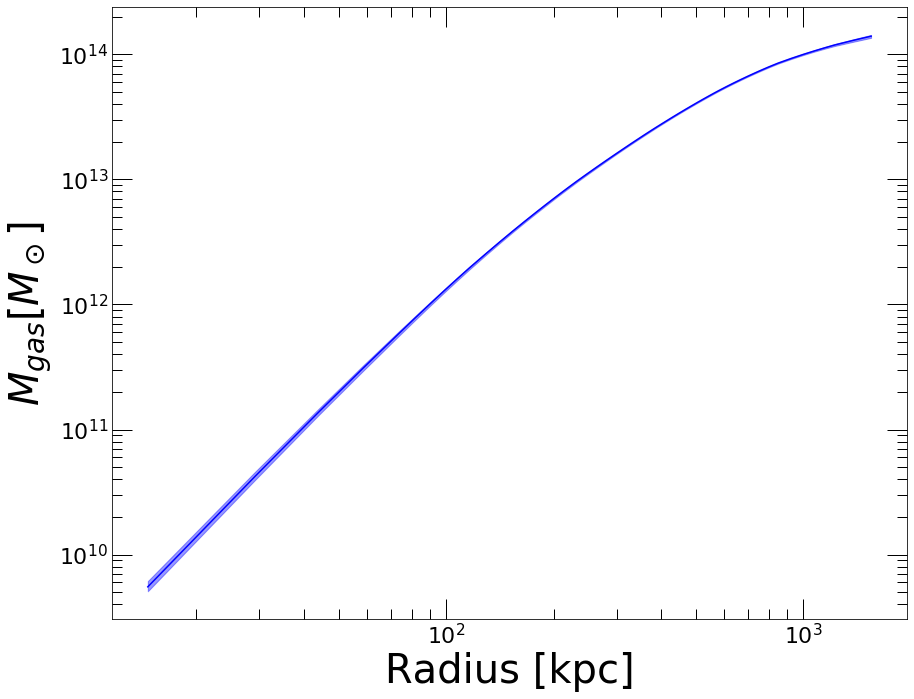

In [41]:
mg, mgl, mgh, fig = hydromass.PlotMgas(mnfwdm, plot=True)

In [42]:
profs_mdm = hydromass.prof_hires(mnfwdm, modnfwdm)

## Let's compare the DM-only + Mgas fit to the standard Mtot fit

<Figure size 432x288 with 0 Axes>

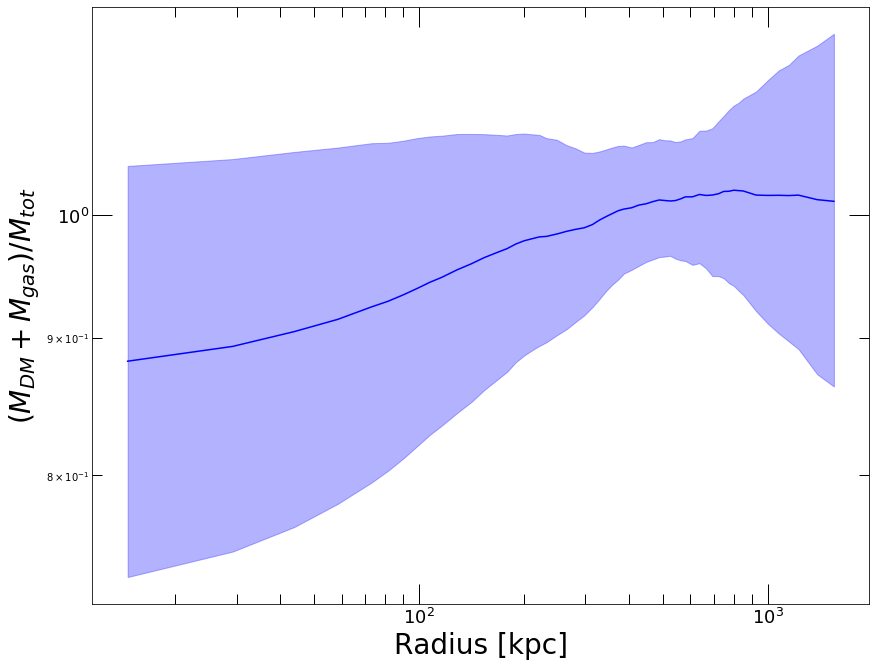

In [43]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=28)
plt.ylabel('$(M_{DM} + M_{gas}) / M_{tot}$', fontsize=28)


tm, tmlo, tmhi = res_mass['MASS'], res_mass['MASS_LO'], res_mass['MASS_HI']

tmdm, tmdmlo, tmdmhi = res_mdm['MASS'], res_mdm['MASS_LO'], res_mdm['MASS_HI']

ratio = (tmdm + mg) / tm

erat_lo = np.sqrt( ((tmdm - tmdmlo) / tm) ** 2 +  ((tmdm + mg) / tm **2 * (tm - tmlo)) ** 2 )

erat_hi = np.sqrt( ((tmdmhi - tmdm) / tm) ** 2 +  ((tmdm + mg) / tm **2 * (tmhi - tm)) ** 2 )

plt.plot(res_mass['R_OUT'], ratio,color='blue')
plt.fill_between(res_mass['R_OUT'], ratio - erat_lo, ratio + erat_hi, color='blue', alpha=0.3)


## Overdensity profiles for DM and gas

<Figure size 432x288 with 0 Axes>

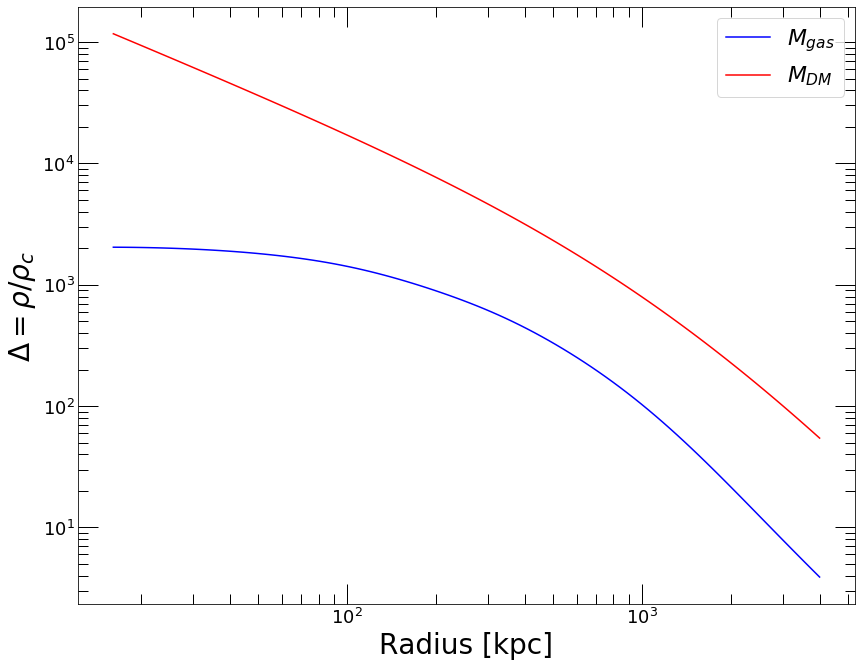

In [44]:
rbt, mbar_ov = hydromass.mbar_overdens(4000., mnfwdm.samples[0], mnfwdm)

plt.clf()
fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=28)
plt.ylabel('$\Delta = \\rho/\\rho_{c}$', fontsize=28)
plt.plot(rbt, mbar_ov, color='blue', label='$M_{gas}$')

mtot_ov = hydromass.delta_func(rbt, mnfwdm, modnfwdm, np.array([mnfwdm.samppar[0]]))
plt.plot(rbt, mtot_ov[0], color='red', label='$M_{DM}$')

plt.legend(fontsize=22)


## Finally write the results for the DM-only run...

In [45]:
hydromass.write_all_mdelta(Mhyd=mnfwdm, model=modnfwdm, outfile=mnfwdm.dir+'/NFW_DMonly.jou')